In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64
  !pip install pytictoc
  !pip install pytictoc --upgrade

import matplotlib.pyplot as plt
import numpy as np 
import pyomo.environ as pyo
from scipy import interpolate
from pytictoc import TicToc

     |████████████████████████████████| 9.2 MB 6.3 MB/s 
     |████████████████████████████████| 49 kB 3.6 MB/s 


# Parameters

In [ ]:
# constants
Rc = 1.94   ## K/W
Ru = 3.19     ## K/W
Cc = 62.7   ## J/K
Cs = 4.5    ## J/K
Rs = Rc     ## checked by jay lee
Cbat = 2.3*3600  # 2.3 Ah
R1 = 0.0123
R2 = 0.0149
C1 = 2575.7
C2 = 84450
R0 = 0.0088

# number of states and inputs
nz = 5
nu = 1

# state and input constraints
SOC_min  ,  SOC_max   =  0.2 , 0.9     # z0, [-] state of charge: how much charge(energy) is in the battery
V1_min   ,  V1_max    = -200 , 200     # z1, [V] C1 voltage
V2_min   ,  V2_max    = -200 , 200     # z2, [V] C2 voltage
Tc_min   ,  Tc_max    =  0  , 45      # z3, [degree celsius] core temperature
Ts_min   ,  Ts_max    =  0  , 45      # z4, [degree celsius] surface temperature
SOH_min  ,  SOH_max   =  -1e5   , 1e5  # z5, [-] state of health: current capacity / original capacity
I_min    ,  I_max     = -35  , 35      # u,  [A] input current
# Vout_min ,  Vout_max  =  2   , 3.6     # y,  [V] output voltage (notated as Vt in the paper)

zMin = np.array([SOC_min, V1_min , V2_min , Tc_min ,Ts_min])
zMax = np.array([SOC_max, V1_max , V2_max , Tc_max ,Ts_max])
uMin = I_min
uMax = I_max

# ocv parameters
p0 = 3.4707
p1 = 1.6112
p2 = -2.6287
p3 = 1.7175

# sub-Functions

In [ ]:
def getNextState(Ts, Tf, Ru, z0, u0):
  ret = np.zeros((nz, 1))
  ret[0] = z0[0] + Ts*( 1/Cbat * u0 )
  ret[1] = z0[1] + Ts*( -z0[1]/(R1*C1) + u0/C1 )
  ret[2] = z0[2] + Ts*( -z0[2]/(R2*C2) + u0/C2 )
  ret[3] = z0[3] + Ts*( (z0[4]-z0[3])/(Rc*Cc) + (u0*(-z0[1]-z0[2]-R0*u0 ))/(Cc) )
  ret[4] = z0[4] + Ts*( (Tf-z0[4])/(Ru*Cs) - (z0[4]-z0[3])/(Rs*Cs) ) ## need to find Rs
  # ret[5] = z0[5] + Ts*( abs(u0)/(2*Ncyc*Cbat) ) ## need to find Ncyc
  return ret


def getOcv(z0):
  return p0 + p1*z0[0] + p2*z0[0]**2 + p3*z0[0]**3


def getOutput(z0, u0):
  ret = getOcv(z0) + z0[1] + z0[2] + R0*u0
  # print('ret = ', ret)
  return ret


# def getNcyc(Tc):
#   Ah = (20 / (30330*np.exp(-31500/(8.314*Tc))))**(1/0.552)
#   nCyc = 3600 * Ah / Cbat
#   # 3600*(20 / (30330*np.exp(-31500/(8.314*Tc))))**(1/0.552)/Cbat
#   return nCyc

##  We will be running optimization many times,
##  so lets make a function for optimization? 
##  so that we can just call it with parameters and keep our main function clean

def runCftoc(Ts, Tf, P, Q, R, N, z0, zf, zL, zU, uL, uU):
  # print("Ts = ", Ts)
  print("Tf = ", Tf)
  # print("P = ", P)
  # print("Q = ", Q)
  # print("R = ", R)
  # print("N = ", N)
  print("z0 = ", z0)
  # print("zf = ", zf)
  # print("zL = ", zL)
  # print("zU = ", zU)
  # print("uL = ", uL)
  # print("uU = ", uU)



  # Write your code here
  model = pyo.ConcreteModel()
  model.tidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
  model.zidx = pyo.Set(initialize=range(0, nz))
  model.uidx = pyo.Set(initialize=range(0, nu))

  # Create state and input variables trajectory:
  model.z = pyo.Var(model.zidx, model.tidx)
  model.u = pyo.Var(model.uidx, model.tidx)
  model.N = N
  model.P = P
  model.Q = Q
  model.R = R
  # print(model.z)
  # print(np.shape(model.z))
  # print(model.u)
  # print(np.shape(model.u))

  # Objective:  
  def objective_rule(model):
    costZ = 0.0
    costU = 0.0
    costTerminal = 0.0

    ### all states and input
    # for t in model.tidx:
    #   for i in model.zidx:   # rows
    #     if t < model.N:    # summation except terminal cost
    #       costZ += model.z[i, t] * model.Q[i, i] * model.z[i, t]
    # for t in model.tidx:
    #   if t < model.N:
    #     costU += model.u[0, t] * model.R * model.u[0, t]
    # for i in model.zidx:
    #   costTerminal += model.z[i, N] * model.P[i, i] * model.z[i, N]
    
    ### only SOC and SOH cost
    # for t in model.tidx:
    #   if t < model.N:
    #     costZ += (model.z[0, t] - zf)*P*(model.z[0, t] - zf)

    ### SOC + current
    for t in model.tidx:
      costZ += 1e2*(model.z[0, t] - zf)**2
      for i in model.zidx:
        if t < model.N: 
          # costZ += 10*model.z[3, t] + 10*model.z[4, t] + (model.z[0, t] - zf)**2
          costZ += model.z[i, t] * model.Q[i, i] * model.z[i, t]
      for t in model.tidx:
        if t < model.N: 
          costU += model.u[0, t] * model.R * model.u[0, t]

    ### only SOH
    # for t in model.tidx:
    #   if t < model.N:
    #     costZ += ( -abs(model.u[0,t])/(2*3600)*(20/30330/pyo.exp(-31500/(8.314*model.z[3, t])))**(-1/0.552) )

    return costZ + costU + costTerminal

  model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

  # print('zf = ', zf)
  # model.cost = pyo.Objective(expr = sum( (model.z[0, t] - zf)**2  for t in model.tidx if t <= N ), sense = pyo.minimize)

  # Constraints:
  # state dynamics equality constraints
  model.constraint1 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + Ts*(model.u[0,t]/Cbat)
                                    if t < N else pyo.Constraint.Skip)
  model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + Ts*(-1/(R1*C1)*model.z[1,t]+1/C1*model.u[0,t])
                                    if t < N else pyo.Constraint.Skip)
  model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[2, t+1] == model.z[2, t] + Ts*(-1/(R2*C2)*model.z[2,t]+1/C2*model.u[0,t])
                                    if t < N else pyo.Constraint.Skip)
  model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[3, t+1] == model.z[3, t] + Ts*((model.z[4,t]-model.z[3,t])/(Rc*Cc)+abs((model.u[0,t]*(-model.z[1,t]-model.z[2,t]-R0*model.u[0,t]))/Cc))
                                    if t < N else pyo.Constraint.Skip)
  model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[4, t+1] == model.z[4, t] + Ts*((Tf-model.z[4,t])/(Ru*Cs)-(model.z[4,t]-model.z[3,t])/(Rs*Cs))
                                    if t < N else pyo.Constraint.Skip)
  

  # basic 2-RC model
  # model.constraint1 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] - Ts*(model.u[0,t]/Cbat)
  #                                   if t < N else pyo.Constraint.Skip)
  # model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + Ts*(-1/(R1*C1)*model.z[1,t]+1/C1*model.u[0,t])
  #                                   if t < N else pyo.Constraint.Skip)
  # model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[2, t+1] == model.z[2, t] + Ts*(-1/(R2*C2)*model.z[2,t]+1/C2*model.u[0,t])
  #                                   if t < N else pyo.Constraint.Skip)
  # model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[3, t+1] == model.z[3, t] + Ts*((1/(Rc*Cc))*(model.z[4,t]-model.z[3,t]) + (1/Cc)*(-(model.z[1,t]) -(model.z[2,t]) - model.u[0,t]*R0)*(-model.u[0,t]))
  #                                   if t < N else pyo.Constraint.Skip)
  # model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[4, t+1] == model.z[4, t] + Ts*((1/(Ru*Cs))*(Tf-model.z[4,t])-(1/(Rc*Cs))*(model.z[4,t]-model.z[3,t]))
  #                                   if t < N else pyo.Constraint.Skip)


  # state constraints
  model.constraint7 = pyo.Constraint(model.zidx, model.tidx, rule=lambda model, i, t: model.z[i, t] <= zU[i]
                                    if t <= N else pyo.Constraint.Skip)
  model.constraint8 = pyo.Constraint(model.zidx, model.tidx, rule=lambda model, i, t: model.z[i, t] >= zL[i] 
                                    if t <= N else pyo.Constraint.Skip)  

  # input constraints
  model.constraint9 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0,t] <= uU
                                    if t < N else pyo.Constraint.Skip)
  model.constraint10= pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0,t] >= uL
                                    if t < N else pyo.Constraint.Skip)

  # initial & final constraints
  model.constraint11= pyo.Constraint(model.zidx, rule=lambda model, i: model.z[i, 0] == z0[i])
  model.constraint12= pyo.Constraint(model.zidx, rule=lambda model, i: model.z[0, N] == zf)

  # Now we can solve:
  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model)
  # results = solver.solve(model, tee=True)
  

  # print('feasible sign = ', str(results.solver.termination_condition))
  if str(results.solver.termination_condition) == "optimal":
    feas = True
  else:
    feas = False

  
  z0_ret = pyo.value(model.z[0,:])
  z1_ret = pyo.value(model.z[1,:])
  z2_ret = pyo.value(model.z[2,:])
  z3_ret = pyo.value(model.z[3,:])
  z4_ret = pyo.value(model.z[4,:])
  # z5_ret = pyo.value(model.z[5,:])

  u_ret  = pyo.value(model.u[0,:])
  # print('u_ret = ', u_ret)
  y_ret  = []

  for i in range(N):
    z0 = np.hstack((z0_ret[i], z1_ret[i], z2_ret[i]))
    y_ret.append(getOutput(z0, u_ret[i]))

  # print(y_ret)

  yOpt = y_ret
  zOpt = np.vstack((z0_ret, z1_ret, z2_ret, z3_ret, z4_ret))
  uOpt = np.array(u_ret)
  jOpt = model.cost()

  print('zOpt = ', np.shape(zOpt))
  print('yOpt = ', np.shape(yOpt))
  print('uOpt = ', np.shape(uOpt))
  print('jOpt = ', jOpt)
  print('feas = ', feas)
  # print(type(zOpt))
  # print(type(uOpt))
  # print(type(jOpt))

  return [model, feas, zOpt, uOpt, yOpt, jOpt]

# Run Single Optimization

Tf =  25
z0 =  [ 0.2  0.   0.  25.  25. ]
zOpt =  (5, 501)
yOpt =  (500,)
uOpt =  (501,)
jOpt =  18231978.936107963
feas =  True
Elapsed time is 35.488245 seconds.
[ 0.59999999  0.0878196   0.03251363 29.32600521 27.664286  ]


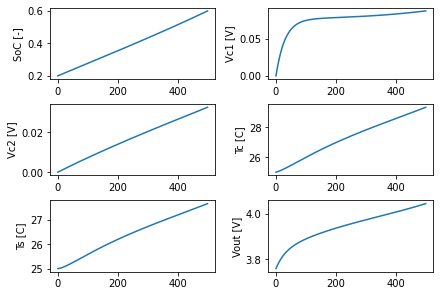

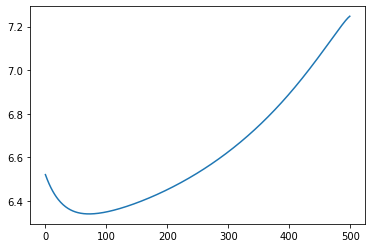

In [ ]:
T_amb = 25
dt = 1   # sec (Ts in cftoc)

######################################
########### MPC parameters ###########
######################################
N  = 500   # 200 sec
M  = 500   # 400 sec
P  = np.array([[0, 0, 0, 0, 0],   # z0: SOC
               [0, 0, 0, 0, 0],   # z1: V1
               [0, 0, 0, 0, 0],   # z2: V2
               [0, 0, 0, 1e1, 0],   # z3: Tc
               [0, 0, 0, 0, 1e1]])  # z4: Ts
Q = P
R = 1



## MPC parameters
runtime = TicToc()

z0 = np.array([0.2, 0, 0, T_amb, T_amb])  ## initial states
SOC_final = 0.6   ## final state
zf = SOC_final    ## final state assignment
zL = zMin         ## lower boundary for states
zU = zMax         ## upper boundary for states
uL = uMin         ## lower boundary for input 
uU = uMax         ## upper boundary for input


zOpt = np.zeros((nz, M+1))
uOpt = np.zeros((nu, M))
jOpt = np.zeros((nu, M))
zOpt[:, 0] = z0.reshape(nz, )

zPred = np.zeros((nz, N+1, M))
predErr = np.zeros((nz, M-N+1))

feas = np.zeros((M, ), dtype=bool)
zN = np.zeros((nz, 1))

runtime.tic() # Start timer

# def runCftoc(Ts, Tf, P, Q, R, N, z0, zf, zL, zU, uL, uU)
[model, feas, z, u, y, j] = runCftoc(dt, T_amb, P, Q, R, N, z0, zf, zL, zU, uL, uU)

runtime.toc() # Time elapsed since t.tic()

print(z[:, -1])

fig, ax = plt.subplots(3,2, constrained_layout=True)
ax[0,0].plot(np.arange(0,N,1), z[0,:-1])
ax[0,1].plot(np.arange(0,N,1), z[1,:-1])
ax[1,0].plot(np.arange(0,N,1), z[2,:-1])
ax[1,1].plot(np.arange(0,N,1), z[3,:-1])
ax[2,0].plot(np.arange(0,N,1), z[4,:-1])
ax[2,1].plot(np.arange(0,N,1), y[:])

ax[0,0].set_ylabel('SoC [-]')
ax[0,1].set_ylabel('Vc1 [V]')
ax[1,0].set_ylabel('Vc2 [V]')
ax[1,1].set_ylabel('Tc [C]')
ax[2,0].set_ylabel('Ts [C]')
ax[2,1].set_ylabel('Vout [V]')
# ax.xlabel('common xlabel')


plt.figure() ## current
plt.plot(np.arange(0,N,1), u[:-1])


# MPC Parameters Setup

In [ ]:
T_amb = 25
dt = 1   # sec (Ts in cftoc)

######################################
########### MPC parameters ###########
######################################
N  = 150   # 200 sec
M  = 800   # 400 sec
P  = np.array([[0, 0, 0, 0, 0],   # z0: SOC
               [0, 0, 0, 0, 0],   # z1: V1
               [0, 0, 0, 0, 0],   # z2: V2
               [0, 0, 0, 1e1, 0],   # z3: Tc
               [0, 0, 0, 0, 1e1]])  # z4: Ts
Q = P
R = 1

## Q0 = 1, 1e1
## Q3 = 1e1
## Q4 = 1e1
## R  = 1
######################################


## MPC parameters
z0 = np.array([0.2, 0, 0, T_amb, T_amb])  ## initial states
SOC_final = 0.6   ## final state
zf = SOC_final    ## final state assignment
zL = zMin         ## lower boundary for states
zU = zMax         ## upper boundary for states
uL = uMin         ## lower boundary for input 
uU = uMax         ## upper boundary for input


# Tf Disturbance Setup

In [ ]:
######################################
########  Tf data generation  ########
######################################
Tf1 = T_amb * np.ones((M+10,))           ## Tf = 25C    during test
Tf2 = np.linspace(25, 45, num = M+10)  ## Tf gradually increases from 25 to 40 during test

## Tf increase from 25 to 45, and cooled 45 to 15
Tf3 = np.hstack((np.linspace(25, 45, num = int(M/3)), np.linspace(45, 15, num = int(2*M/3)+10)))   

# Scenario 1 - Run MPC @ Tf = 25

In [ ]:
zOpt1 = np.zeros((nz, M+1))       ## storage for optimal state data
yOpt1 = np.zeros((nu, M+1))       ## storage for optimal output calculated from optimal states
uOpt1 = np.zeros((nu, M))         ## storage for optimal control (input)
jOpt1 = np.zeros((nu, M))         ## storage for cost : here, we want to see Lyapunov properties.   1) monotonically decreasing cost    2) ???
zOpt1[:, 0] = z0    ## initial state assignment

print('z0 = ', z0)
print('zOpt1[0] = ', zOpt1[:, 0])

zPred1 = np.zeros((nz, N+1, M))
predErr1 = np.zeros((nz, M-N+1))

feas1 = np.zeros((M, ), dtype=bool)   ## storage for feasibility data
zN1 = np.zeros((nz, 1))

runtime = TicToc()

for t in range(M): 
  print('****************************')
  print('******  Cycle Starts  ******')
  print('****************************')

  runtime.tic() #Start timer

  print('t = ', t)
  # [model, feas, zOpt, uOpt, yOpt, jOpt] = runCftoc(Ts, Tf, P, Q, R, N, z0, zf, zL, zU, uL, uU)
  [model, feas1[t], z, u, y, j] = runCftoc(dt, Tf1[t], P, Q, R, N, zOpt1[:, t], zf, zL, zU, uL, uU)  ## closed loop

  if not feas1[t]:
    zOpt1 = []
    uOpt1 = []
    jOpt1 = []
    predErr1 = []
    break

      ## open loop
  zPred1[:, :, t] = z

  #     ## plot open loop
  #     # line1 = plt.plot(z[0,:], z[1,:], 'r--')

  ## closed loop
  zOpt1[:, t+1] = z[:, 1]
  uOpt1[:, t] = u[0]
  yOpt1[:, t] = y[0]
  jOpt1[:, t] = j

  print('zOpt = ', zOpt1[:, t])
  print('zOpt = ', zOpt1[:, t+1])
  print('uOpt = ', uOpt1[:, t])
  print('yOpt = ', yOpt1[:, t])
  print('jOpt = ', jOpt1[:, t])

  runtime.toc() #Time elapsed since t.tic()

  print('****************************')
  print('*****  One Cycle Done  *****')
  print('****************************\n')


  # for t in range(len(predErr)):
  #   err = zOpt[:, t:t+N+1] - zPred[:, :, t]
  #   predErr[:, t] = np.array([np.linalg.norm(err[0, :]), np.linalg.norm(err[1, :])]).reshape(nz, )

Streaming output truncated to the last 5000 lines.
uOpt =  [0.57800701]
yOpt =  [3.89881435]
jOpt =  [2150509.57353603]
Elapsed time is 2.381494 seconds.
****************************
*****  One Cycle Done  *****
****************************

****************************
******  Cycle Starts  ******
****************************
t =  592
Tf =  25.0
z0 =  [5.87195981e-01 8.69230181e-03 2.68407176e-02 2.75452190e+01
 2.66078135e+01]
zOpt =  (5, 151)
yOpt =  (150,)
uOpt =  (151,)
jOpt =  2149580.871299242
feas =  True
zOpt =  [5.87195981e-01 8.69230181e-03 2.68407176e-02 2.75452190e+01
 2.66078135e+01]
zOpt =  [5.87265389e-01 8.64101881e-03 2.68261903e-02 2.75378845e+01
 2.66031873e+01]
uOpt =  [0.57460203]
yOpt =  [3.89873929]
jOpt =  [2149580.87129924]
Elapsed time is 2.379363 seconds.
****************************
*****  One Cycle Done  *****
****************************

****************************
******  Cycle Starts  ******
****************************
t =  593
Tf =  25.0
z0 =  [5.87

# Scenario 1 - Plot

zOpt shape =  (5, 801)
uOpt shape =  (1, 800)
yOpt shape =  (1, 801)
jOpt shape =  (1, 800)


Text(0.5, 0, 'time  [s]')

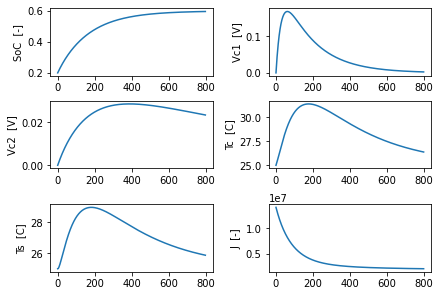

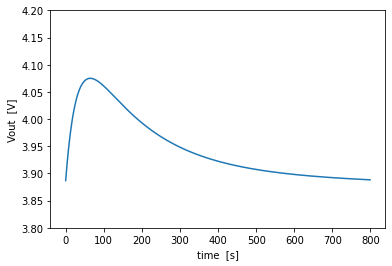

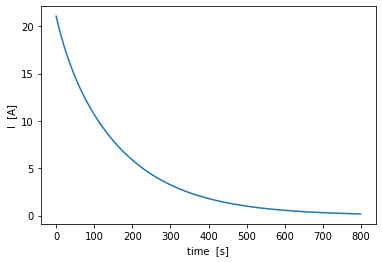

In [ ]:
print('zOpt shape = ', np.shape(zOpt1))
print('uOpt shape = ', np.shape(uOpt1))
print('yOpt shape = ', np.shape(yOpt1))
print('jOpt shape = ', np.shape(jOpt1))

fig, ax = plt.subplots(3,2, constrained_layout=True)
ax[0,0].plot(np.arange(0,M,1), zOpt1[0,:-1])
ax[0,1].plot(np.arange(0,M,1), zOpt1[1,:-1])
ax[1,0].plot(np.arange(0,M,1), zOpt1[2,:-1])
ax[1,1].plot(np.arange(0,M,1), zOpt1[3,:-1])
ax[2,0].plot(np.arange(0,M,1), zOpt1[4,:-1])
ax[2,1].plot(np.arange(0,M,1), jOpt1[0,:])

# plt.title("Scenario 1")
ax[0,0].set_ylabel('SoC  [-]')
ax[0,1].set_ylabel('Vc1  [V]')
ax[1,0].set_ylabel('Vc2  [V]')
ax[1,1].set_ylabel('Tc  [C]')
ax[2,0].set_ylabel('Ts  [C]')
ax[2,1].set_ylabel('J  [-]')
# ax.xlabel('common xlabel')
# ax[0,0].set_ylim([0.2, 0.65])
# ax[0,1].set_ylim([0, 0.2])
# ax[1,0].set_ylim([0, 0.035])
# ax[1,1].set_ylim([25, 40])
# ax[2,0].set_ylim([25, 40])
# ax[2,1].set_ylim([0, 1.5e7])

# plt.title("Scenario 1")
plt.figure() ## current
plt.plot(np.arange(0,M,1), yOpt1[0, :-1])
plt.ylabel('Vout  [V]')
plt.ylim([3.8, 4.2])
plt.xlabel('time  [s]')

# plt.title("Scenario 1")
plt.figure() ## current
plt.plot(np.arange(0,M,1), uOpt1[0, :])
plt.ylabel('I  [A]')
plt.xlabel('time  [s]')

# Scenario 2 - Run MPC @ Tf = 25 -> 45 (Tf Linearly Increases)

In [ ]:
zOpt2 = np.zeros((nz, M+1))       ## storage for optimal state data
yOpt2 = np.zeros((nu, M+1))       ## storage for optimal output calculated from optimal states
uOpt2 = np.zeros((nu, M))         ## storage for optimal control (input)
jOpt2 = np.zeros((nu, M))         ## storage for cost : here, we want to see Lyapunov properties.   1) monotonically decreasing cost    2) ???
zOpt2[:, 0] = z0    ## initial state assignment

print('z0 = ', z0)
print('zOpt1[0] = ', zOpt2[:, 0])

zPred2 = np.zeros((nz, N+1, M))
predErr2 = np.zeros((nz, M-N+1))

feas2 = np.zeros((M, ), dtype=bool)   ## storage for feasibility data
zN2 = np.zeros((nz, 1))

runtime = TicToc()

for t in range(M): 
  print('****************************')
  print('******  Cycle Starts  ******')
  print('****************************')

  runtime.tic() #Start timer

  print('t = ', t)
  # [model, feas, zOpt, uOpt, yOpt, jOpt] = runCftoc(Ts, Tf, P, Q, R, N, z0, zf, zL, zU, uL, uU)
  [model, feas2[t], z, u, y, j] = runCftoc(dt, Tf2[t], P, Q, R, N, zOpt2[:, t], zf, zL, zU, uL, uU)  ## closed loop

  if not feas1[t]:
    zOpt2 = []
    uOpt2 = []
    jOpt2 = []
    predErr2 = []
    break

      ## open loop
  zPred2[:, :, t] = z

  #     ## plot open loop
  #     # line1 = plt.plot(z[0,:], z[1,:], 'r--')

  ## closed loop
  zOpt2[:, t+1] = z[:, 1]
  uOpt2[:, t] = u[0]
  yOpt2[:, t] = y[0]
  jOpt2[:, t] = j

  print('zOpt = ', zOpt2[:, t])
  print('zOpt = ', zOpt2[:, t+1])
  print('uOpt = ', uOpt2[:, t])
  print('yOpt = ', yOpt2[:, t])
  print('jOpt = ', jOpt2[:, t])

  runtime.toc() #Time elapsed since t.tic()

  print('****************************')
  print('*****  One Cycle Done  *****')
  print('****************************\n')

  # for t in range(len(predErr)):
  #   err = zOpt[:, t:t+N+1] - zPred[:, :, t]
  #   predErr[:, t] = np.array([np.linalg.norm(err[0, :]), np.linalg.norm(err[1, :])]).reshape(nz, )

Streaming output truncated to the last 5000 lines.
uOpt =  [0.58089295]
yOpt =  [3.89855326]
jOpt =  [4067959.52779835]
Elapsed time is 2.699324 seconds.
****************************
*****  One Cycle Done  *****
****************************

****************************
******  Cycle Starts  ******
****************************
t =  592
Tf =  39.635352286773795
z0 =  [5.86357608e-01 8.71813729e-03 2.67806368e-02 3.52471826e+01
 3.68118006e+01]
zOpt =  (5, 151)
yOpt =  (150,)
uOpt =  (151,)
jOpt =  4071580.943517283
feas =  True
zOpt =  [5.86357608e-01 8.71813729e-03 2.67806368e-02 3.52471826e+01
 3.68118006e+01]
zOpt =  [5.86427371e-01 8.66716509e-03 2.67661912e-02 3.52604193e+01
 3.68292721e+01]
uOpt =  [0.5775033]
yOpt =  [3.89847879]
jOpt =  [4071580.94351728]
Elapsed time is 2.947243 seconds.
****************************
*****  One Cycle Done  *****
****************************

****************************
******  Cycle Starts  ******
****************************
t =  593
Tf =  39.

# Scenario 2 - Plot

zOpt shape =  (5, 801)
uOpt shape =  (1, 800)
yOpt shape =  (1, 801)
jOpt shape =  (1, 800)


Text(0.5, 0, 'time  [s]')

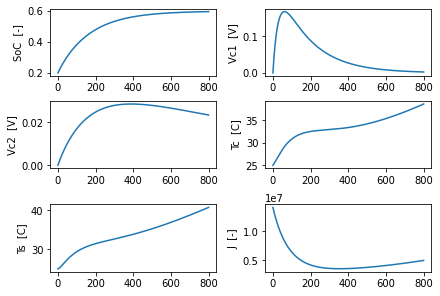

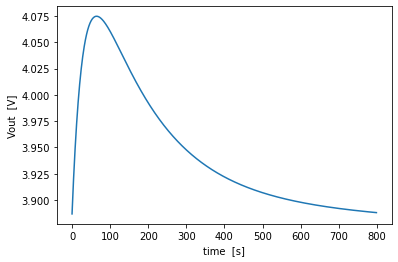

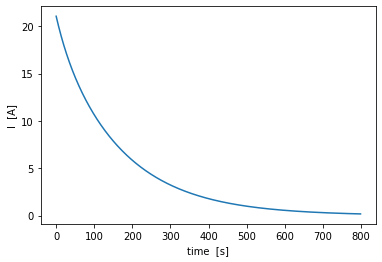

In [ ]:
print('zOpt shape = ', np.shape(zOpt2))
print('uOpt shape = ', np.shape(uOpt2))
print('yOpt shape = ', np.shape(yOpt2))
print('jOpt shape = ', np.shape(jOpt2))

fig, ax = plt.subplots(3,2, constrained_layout=True)
ax[0,0].plot(np.arange(0,M,1), zOpt2[0,:-1])
ax[0,1].plot(np.arange(0,M,1), zOpt2[1,:-1])
ax[1,0].plot(np.arange(0,M,1), zOpt2[2,:-1])
ax[1,1].plot(np.arange(0,M,1), zOpt2[3,:-1])
ax[2,0].plot(np.arange(0,M,1), zOpt2[4,:-1])
ax[2,1].plot(np.arange(0,M,1), jOpt2[0,:])

# plt.title("Scenario 1")
ax[0,0].set_ylabel('SoC  [-]')
ax[0,1].set_ylabel('Vc1  [V]')
ax[1,0].set_ylabel('Vc2  [V]')
ax[1,1].set_ylabel('Tc  [C]')
ax[2,0].set_ylabel('Ts  [C]')
ax[2,1].set_ylabel('J  [-]')
# ax.xlabel('common xlabel')

# plt.title("Scenario 1")
plt.figure() ## current
plt.plot(np.arange(0,M,1), yOpt2[0, :-1])
plt.ylabel('Vout  [V]')
plt.xlabel('time  [s]')

# plt.title("Scenario 1")
plt.figure() ## current
plt.plot(np.arange(0,M,1), uOpt2[0, :])
plt.ylabel('I  [A]')
plt.xlabel('time  [s]')





# Scenario 3 - Run MPC @ Rf = 25 -> 45 -> 15 (Tf Linearly Increase -> Tf Linearly Decrease)

In [ ]:
zOpt3 = np.zeros((nz, M+1))       ## storage for optimal state data
yOpt3 = np.zeros((nu, M+1))       ## storage for optimal output calculated from optimal states
uOpt3 = np.zeros((nu, M))         ## storage for optimal control (input)
jOpt3 = np.zeros((nu, M))         ## storage for cost : here, we want to see Lyapunov properties.   1) monotonically decreasing cost    2) ???
zOpt3[:, 0] = z0    ## initial state assignment

print('z0 = ', z0)
print('zOpt3[0] = ', zOpt3[:, 0])

zPred3 = np.zeros((nz, N+1, M))
predErr3 = np.zeros((nz, M-N+1))

feas3 = np.zeros((M, ), dtype=bool)   ## storage for feasibility data
zN3 = np.zeros((nz, 1))

runtime = TicToc()

for t in range(M): 
  print('****************************')
  print('******  Cycle Starts  ******')
  print('****************************')

  runtime.tic() #Start timer

  print('t = ', t)
  # [model, feas, zOpt, uOpt, yOpt, jOpt] = runCftoc(Ts, Tf, P, Q, R, N, z0, zf, zL, zU, uL, uU)
  [model, feas3[t], z, u, y, j] = runCftoc(dt, Tf3[t], P, Q, R, N, zOpt3[:, t], zf, zL, zU, uL, uU)  ## closed loop

  if not feas1[t]:
    zOpt3 = []
    uOpt3 = []
    jOpt3 = []
    predErr3 = []
    break

      ## open loop
  zPred3[:, :, t] = z

  #     ## plot open loop
  #     # line1 = plt.plot(z[0,:], z[1,:], 'r--')

  ## closed loop
  zOpt3[:, t+1] = z[:, 1]
  uOpt3[:, t] = u[0]
  yOpt3[:, t] = y[0]
  jOpt3[:, t] = j

  print('zOpt = ', zOpt3[:, t])
  print('zOpt = ', zOpt3[:, t+1])
  print('uOpt = ', uOpt3[:, t])
  print('yOpt = ', yOpt3[:, t])
  print('jOpt = ', jOpt3[:, t])

  runtime.toc() #Time elapsed since t.tic()

  print('****************************')
  print('*****  One Cycle Done  *****')
  print('****************************\n')

  # for t in range(len(predErr)):
  #   err = zOpt[:, t:t+N+1] - zPred[:, :, t]
  #   predErr[:, t] = np.array([np.linalg.norm(err[0, :]), np.linalg.norm(err[1, :])]).reshape(nz, )

Streaming output truncated to the last 5000 lines.
uOpt =  [0.61599292]
yOpt =  [3.89913013]
jOpt =  [3273747.09786316]
Elapsed time is 2.649684 seconds.
****************************
*****  One Cycle Done  *****
****************************

****************************
******  Cycle Starts  ******
****************************
t =  592
Tf =  26.95571955719557
z0 =  [5.85850381e-01 9.15691458e-03 2.67633557e-02 3.59462294e+01
 3.27456796e+01]
zOpt =  (5, 151)
yOpt =  (150,)
uOpt =  (151,)
jOpt =  3266512.2980980873
feas =  True
zOpt =  [5.85850381e-01 9.15691458e-03 2.67633557e-02 3.59462294e+01
 3.27456796e+01]
zOpt =  [5.85924375e-01 9.10570500e-03 2.67493393e-02 3.59203209e+01
 3.27089537e+01]
uOpt =  [0.61256467]
yOpt =  [3.89905676]
jOpt =  [3266512.29809809]
Elapsed time is 2.548018 seconds.
****************************
*****  One Cycle Done  *****
****************************

****************************
******  Cycle Starts  ******
****************************
t =  593
Tf =  26

# Scenario 3 - Plot

zOpt shape =  (5, 801)
uOpt shape =  (1, 800)
yOpt shape =  (1, 801)
jOpt shape =  (1, 800)


Text(0.5, 0, 'time  [s]')

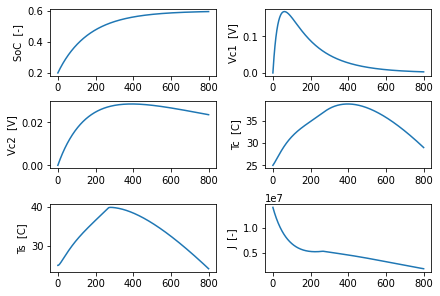

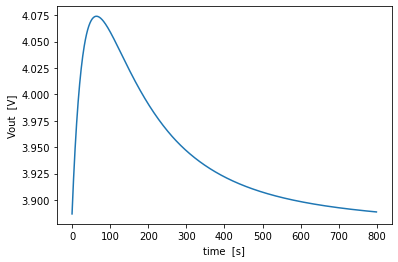

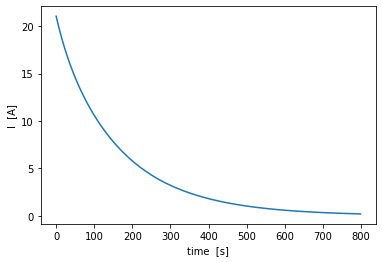

In [ ]:
print('zOpt shape = ', np.shape(zOpt3))
print('uOpt shape = ', np.shape(uOpt3))
print('yOpt shape = ', np.shape(yOpt3))
print('jOpt shape = ', np.shape(jOpt3))

fig, ax = plt.subplots(3,2, constrained_layout=True)
ax[0,0].plot(np.arange(0,M,1), zOpt3[0,:-1])
ax[0,1].plot(np.arange(0,M,1), zOpt3[1,:-1])
ax[1,0].plot(np.arange(0,M,1), zOpt3[2,:-1])
ax[1,1].plot(np.arange(0,M,1), zOpt3[3,:-1])
ax[2,0].plot(np.arange(0,M,1), zOpt3[4,:-1])
ax[2,1].plot(np.arange(0,M,1), jOpt3[0,:])

# plt.title("Scenario 1")
ax[0,0].set_ylabel('SoC  [-]')
ax[0,1].set_ylabel('Vc1  [V]')
ax[1,0].set_ylabel('Vc2  [V]')
ax[1,1].set_ylabel('Tc  [C]')
ax[2,0].set_ylabel('Ts  [C]')
ax[2,1].set_ylabel('J  [-]')
# ax.xlabel('common xlabel')

# plt.title("Scenario 1")
plt.figure() ## current
plt.plot(np.arange(0,M,1), yOpt3[0, :-1])
plt.ylabel('Vout  [V]')
plt.xlabel('time  [s]')

# plt.title("Scenario 1")
plt.figure() ## current
plt.plot(np.arange(0,M,1), uOpt3[0, :])
plt.ylabel('I  [A]')
plt.xlabel('time  [s]')

# Compare Plots

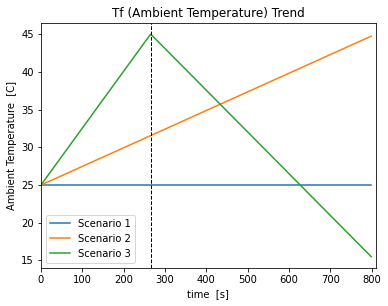

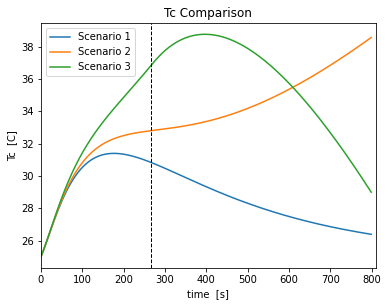

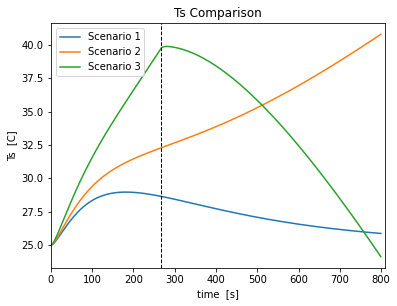

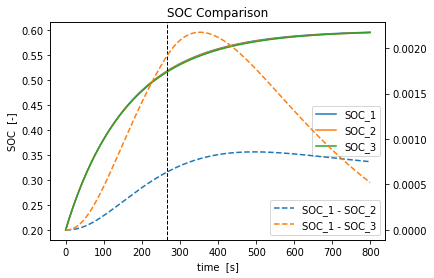

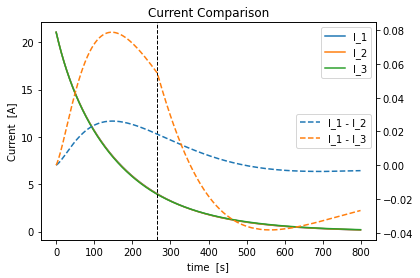

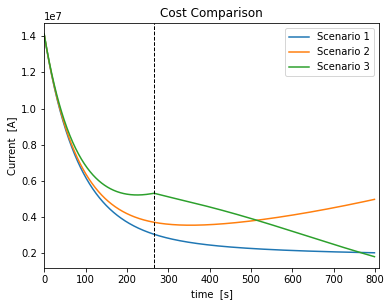

In [ ]:
## Plot Ambient Temperaure Difference
plt.figure(figsize=(6, 4.5))
plt.title('Tf (Ambient Temperature) Trend')
plt.plot(np.arange(0,M,1), Tf1[:-10])
plt.plot(np.arange(0,M,1), Tf2[:-10])
plt.plot(np.arange(0,M,1), Tf3[:-9])
plt.axvline(x=int(M/3), c='k', ls='--', lw=1)
plt.xlim([0, 810])
plt.ylabel('Ambient Temperature  [C]')
plt.xlabel('time  [s]')
plt.legend(['Scenario 1', 'Scenario 2', 'Scenario 3'])
plt.show()

## Battery Core Temperature Difference
plt.figure(figsize=(6, 4.5)) ## current
plt.title("Tc Comparison")
plt.plot(np.arange(0,M,1), zOpt1[3,:-1])
plt.plot(np.arange(0,M,1), zOpt2[3,:-1])
plt.plot(np.arange(0,M,1), zOpt3[3,:-1])
plt.axvline(x=int(M/3), c='k', ls='--', lw=1)
plt.xlim([0, 810])
plt.ylabel('Tc  [C]')
plt.xlabel('time  [s]')
plt.legend(['Scenario 1', 'Scenario 2', 'Scenario 3'])
plt.show()

## Battery Surface Temperature Difference
plt.figure(figsize=(6, 4.5)) ## current
plt.title("Ts Comparison")
plt.plot(np.arange(0,M,1), zOpt1[4,:-1])
plt.plot(np.arange(0,M,1), zOpt2[4,:-1])
plt.plot(np.arange(0,M,1), zOpt3[4,:-1])
plt.axvline(x=int(M/3), c='k', ls='--', lw=1)
plt.xlim([0, 810])
plt.ylabel('Ts  [C]')
plt.xlabel('time  [s]')
plt.legend(['Scenario 1', 'Scenario 2', 'Scenario 3'])
plt.show()

## Battery SOC(z0) Difference
z12_Err = zOpt1[0,:]-zOpt2[0,:]
z13_Err = zOpt1[0,:]-zOpt3[0,:]
fig, ax = plt.subplots()
ax.title.set_text('SOC Comparison')
ax.plot(np.arange(0,M,1), zOpt1[0,:-1])
ax.plot(np.arange(0,M,1), zOpt2[0,:-1])
ax.plot(np.arange(0,M,1), zOpt3[0,:-1])
ax.axvline(x=int(M/3), c='k', ls='--', lw=1)
ax.set_xlabel('time  [s]')
ax.set_ylabel('SOC  [-]')
ax.legend(['SOC_1', 'SOC_2', 'SOC_3'], loc='center right')
ax2 = ax.twinx()
ax2.plot(np.arange(0,M,1), z12_Err[:-1], ls='--')
ax2.plot(np.arange(0,M,1), z13_Err[:-1], ls='--')
ax2.legend(['SOC_1 - SOC_2', 'SOC_1 - SOC_3'], loc='lower right')
plt.show()

## Current Input Difference
u12_Err = uOpt1[0,:]-uOpt2[0,:]
u13_Err = uOpt1[0,:]-uOpt3[0,:]
fig, ax = plt.subplots()
ax.title.set_text('Current Comparison')
ax.plot(np.arange(0,M,1), uOpt1[0,:])
ax.plot(np.arange(0,M,1), uOpt2[0,:])
ax.plot(np.arange(0,M,1), uOpt3[0,:])
ax.axvline(x=int(M/3), c='k', ls='--', lw=1)
ax.set_xlabel('time  [s]')
ax.set_ylabel('Current  [A]')
ax.legend(['I_1', 'I_2', 'I_3'], loc='upper right')
ax2 = ax.twinx()
ax2.plot(np.arange(0,M,1), u12_Err[:], ls='--')
ax2.plot(np.arange(0,M,1), u13_Err[:], ls='--')
ax2.legend(['I_1 - I_2', 'I_1 - I_3'], loc='center right')
plt.show()


## Cost Difference
plt.figure(figsize=(6, 4.5))
plt.title('Cost Comparison')
plt.plot(np.arange(0,M,1), jOpt1[0,:])
plt.plot(np.arange(0,M,1), jOpt2[0,:])
plt.plot(np.arange(0,M,1), jOpt3[0,:])
plt.axvline(x=int(M/3), c='k', ls='--', lw=1)
plt.xlim([0, 810])
plt.ylabel('Current  [A]')
plt.xlabel('time  [s]')
plt.legend(['Scenario 1', 'Scenario 2', 'Scenario 3'])
plt.show()
